<a href="https://colab.research.google.com/github/Rapanda1/Final-Year-Project-CM3070/blob/main/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to Google drive

In [ ]:
# mount gdrive, required for downloaded dataset
import os
from google.colab import drive
drive.mount("/content/drive")

# !mkdir -p /content/drive/MyDrive/FYP\ Networks
# !mkdir -p /content/drive/MyDrive/FYP\ Networks/Adult\ income
# !mkdir -p /content/drive/MyDrive/FYP\ Networks/Adult\ income/data

# URL for the dataset, Adult.csv
URL = "https://drive.google.com/file/d/1dkz-zkgqjmm6Oy9JSkE9pbYjAx_-gFOr/view?usp=drive_link"
DOWNLOAD_FILE_PATH = "https://drive.google.com/uc?export=download&id=" + URL.split("/")[-2]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing of libraries and loading data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import keras_tuner as kt

# Load the dataset
FILE_PATH = "/content/drive/MyDrive/FYP Networks/Adult income/data/adult.csv" #Pointing to the dataset location


In [ ]:
# Load the dataset
columns = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(FILE_PATH, names=columns, na_values=' ?', skipinitialspace=True)

# Handle missing values
data.dropna(inplace=True)

# Encode categorical features
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    encoder = LabelEncoder()
    data[column] = encoder.fit_transform(data[column])

# Split the dataset
X = data.drop('income', axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
def build_model(hp):
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
               kernel_size=hp.Choice('conv1_kernel_size', values=[2, 3]),
               activation='relu',
               kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.01, 0.001]))),
        BatchNormalization(),
        Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)),
        Conv1D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
               kernel_size=hp.Choice('conv2_kernel_size', values=[2, 3]),
               activation='relu',
               kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.01, 0.001]))),
        BatchNormalization(),
        Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'),
        BatchNormalization(),
        Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='cnn_adult_income'
)

# Perform hyperparameter tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 20 Complete [00h 11m 46s]
val_accuracy: 0.8439752459526062

Best val_accuracy So Far: 0.8525911569595337
Total elapsed time: 06h 25m 28s


Epoch 1/50
977/977 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7759 - loss: 0.6127 - val_accuracy: 0.8389 - val_loss: 0.4127 - learning_rate: 0.0010
Epoch 2/50
977/977 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8246 - loss: 0.4243 - val_accuracy: 0.8403 - val_loss: 0.3709 - learning_rate: 0.0010
Epoch 3/50
977/977 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8323 - loss: 0.3834 - val_accuracy: 0.8374 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 4/50
977/977 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8342 - loss: 0.3714 - val_accuracy: 0.8369 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 5/50
977/977 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8383 - loss: 0.3607 - val_accuracy: 0.8370 - val_loss: 0.3565 - learning_rate: 0.0010
Epoch 6/50
977/977 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8321 - loss: 0.3724 - val_accuracy: 0.8417 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 7/50
977/977 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8391 - loss

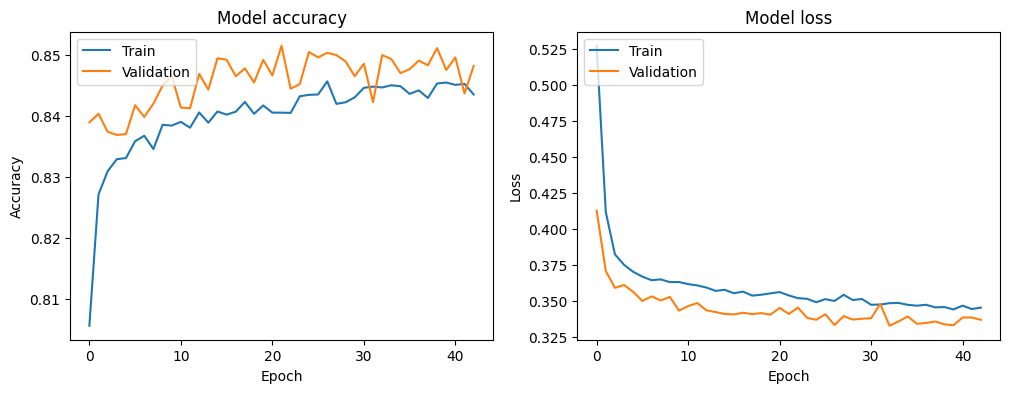

In [ ]:
# Build the best model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Generate a classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
